Скачивание недостающих библиотек

In [ ]:
!pip install transformers
!pip install torch

Требовалось разработать модель, способную классифицировать тексты эссе на два класса:

0 (написано студентом)

1 (сгенерировано нейросетью, например, ChatGPT)

Это задача бинарной классификации, где качество модели оценивается по точности (accuracy) на валидационной выборке.

Структура данных:

Датасет содержал тексты эссе и соответствующие метки (generated: 0 или 1).

Тексты были предварительно очищены от лишних символов (например, \n).

Разделение на train/val уже было выполнено (загружались из .parquet).

Особенности текстов:

Эссе могли быть разной длины, поэтому требовалась унифицированная обработка (padding/truncation).

Возможные признаки различия: стиль, структура предложений, использование шаблонных фраз (у ИИ) или индивидуальные особенности (у студентов).

In [ ]:
import pandas as pd
import os
import torch
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

# Загрузка данных
DATA_PATH = '/content/drive/MyDrive/Datasets/Plagiat data'
train_parquet_path = os.path.join(DATA_PATH, 'train_essays.parquet')
val_parquet_path = os.path.join(DATA_PATH, 'valid_essays.parquet')
train = pd.read_parquet(train_parquet_path)
val = pd.read_parquet(val_parquet_path)

X_train = train["text"].values
y_train = train["generated"].values
X_val = val["text"].values
y_val = val["generated"].values

# Создание кастомного Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Параметры
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5
MODEL_SAVE_PATH = '/content/drive/MyDrive/Models/essay_classifier'

# Инициализация токенизатора и модели
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Создание DataLoader
train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = TextDataset(X_val, y_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Настройка оптимизатора и устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Функция для тренировки
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0
    total_samples = 0

    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        losses.append(loss.item())

        # Вычисляем точность для текущего батча
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)
        batch_acc = torch.sum(preds == labels).double() / labels.size(0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Выводим прогресс каждые N батчей
        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == len(data_loader):
            print(f'Batch {batch_idx + 1}/{len(data_loader)} | '
                  f'Loss: {loss.item():.4f} | '
                  f'Batch Acc: {batch_acc:.4f} | '
                  f'Running Acc: {correct_predictions.double() / total_samples:.4f}')

    epoch_loss = sum(losses) / len(losses)
    epoch_acc = correct_predictions.double() / total_samples
    print(f'\nEpoch summary: Avg Loss: {epoch_loss:.4f} | Avg Acc: {epoch_acc:.4f}\n')
    return epoch_loss

# Функция для валидации
def eval_model(model, data_loader, device):
    model = model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    return accuracy_score(actual_labels, predictions)

# Тренировка модели
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss: {train_loss}')

    val_acc = eval_model(model, val_loader, device)
    print(f'Validation accuracy: {val_acc}')
    print()

# Для сохранения лучшей модели
best_val_acc = 0.0

def save_model(model, tokenizer, save_path, model_name):
    """Сохраняет модель и токенизатор"""
    output_dir = os.path.join(save_path, model_name)
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Модель сохранена в {output_dir}")

# Отслеживаем метрику на каждой эпохе
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Обучение
    train_loss = train_epoch(model, train_loader, optimizer, device)

    # Валидация
    val_acc = eval_model(model, val_loader, device)
    print(f'Validation accuracy: {val_acc:.4f}')

    # Сохраняем лучшую модель
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_model(model, tokenizer, MODEL_SAVE_PATH, 'best_model')
        print(f"Новая лучшая модель с точностью {val_acc:.4f}!")

    # Сохраняем последнюю модель
    save_model(model, tokenizer, MODEL_SAVE_PATH, 'last_model')
    print()

При BATCH_SIZE = 16 и MAX_LENGTH = 256

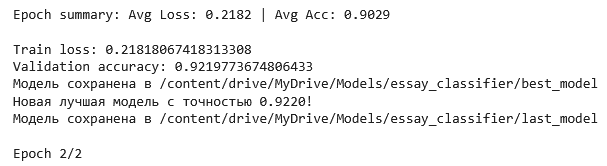

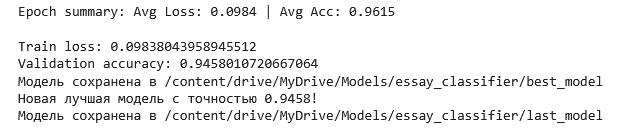

Пример:

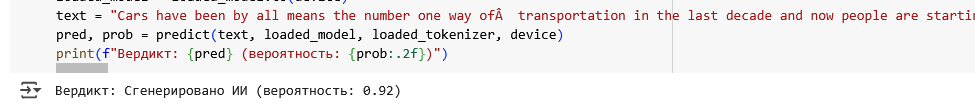

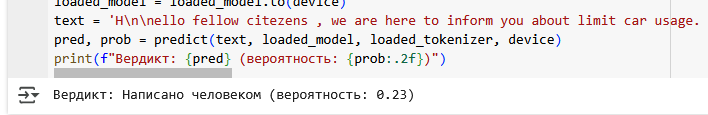

При BATCH_SIZE = 8 и MAX_LENGTH = 128

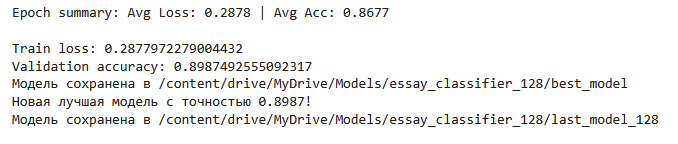

Пример:

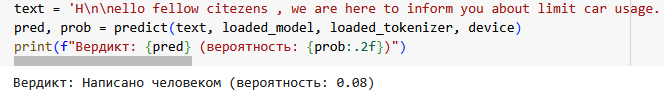

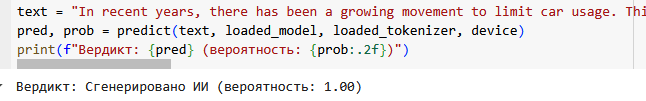

roberta при BATCH_SIZE = 16 и MAX_LENGTH = 256

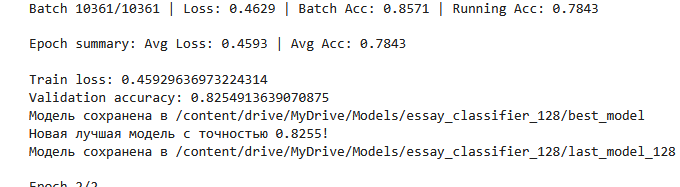

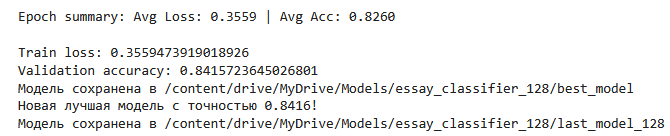

Были протестированы несколько вариантов:

BERT-base (bert-base-uncased) – показал наилучший результат (val_accuracy ≈ 0.92).

DeBERTa и RoBERTa – давали accuracy 0.84–0.89, но обучались дольше.

Для достижения лучшего результата были выбраны:

Модель: BertForSequenceClassification (дообучение верхних слоёв).

Длина текста: MAX_LENGTH = 256 (уменьшение до 128 ухудшало accuracy).

Размер батча: BATCH_SIZE = 16 (максимально возможный для T4).

Learning rate: 2e-5 (стандартное значение для дообучения BERT).

Количество эпох: 2 (увеличение до 4+ давало прирост 1-3%, но обучалось в 2 раза дольше).

Обучение производилось с помощью процессора T4, который предоставлял Google Colab

Загрузка модели:

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

model_path = '/content/drive/MyDrive/Models/essay_classifier_128/best_model'
loaded_model = BertForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)

Проверка модели:

In [ ]:
def predict(text, model, tokenizer, device, max_len=128):
    model.eval()
    encoding = tokenizer(
        text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs).item()

    return "Сгенерировано ИИ" if pred == 1 else "Написано человеком", probs[0][1].item()

# Пример
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = loaded_model.to(device)
text = "In recent years, there has been a growing movement to limit car usage. This is due to a number of factors, including the increasing cost of owning a car, the environmental impact of car emissions, and the growing popularity of alternative forms of transportation, such as walking, biking, and public transit.\n\nThere are many benefits to limiting car usage. For one, it can save you money. The average car payment in the United States is over $500 per month, and that doesn't include the cost of gas, insurance, and maintenance. If you can get by without a car, you can save a significant amount of money each month.\n\nLimiting car usage can also help the environment. Cars are a major source of air pollution, and they contribute to climate change. By choosing to walk, bike, or take public transit instead of driving, you can reduce your impact on the environment.\n\nFinally, limiting car usage can make your life more enjoyable. When you don't have to worry about driving, you have more time to relax and enjoy your surroundings. You can also get more exercise and socialize more, both of which are good for your health.\n\nIf you're thinking about limiting your car usage, there are a few things you can do to make the transition easier. First, try to live in a neighborhood that is walkable and bikeable. This will make it easier to get around without a car. Second, invest in a good pair of walking shoes or a bicycle. Third, find out about public transit options in your area. Many cities have excellent public transit systems that can take you where you need to go.\n\nLimiting car usage can be a great way to save money, help the environment, and improve your quality of life. If you're thinking about making the switch, there are a number of resources available to help you get started."
pred, prob = predict(text, loaded_model, loaded_tokenizer, device)
print(f"Вердикт: {pred} (вероятность: {prob:.2f})")